# QAA Pulser

In [1]:
import numpy as np
import json

import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import networkx as nx
from collections import defaultdict

from pulser import Pulse, Sequence, Register
from pulser.waveforms import CompositeWaveform, ConstantWaveform, RampWaveform, InterpolatedWaveform
from pulser.devices import AnalogDevice, DigitalAnalogDevice

from pulser_simulation import SimConfig, QutipEmulator

from pulser.json.abstract_repr.deserializer import deserialize_device

from pasqal_cloud import SDK, BatchFilters
from pasqal_cloud.device import EmulatorType

/home/andrea24/micromamba/envs/pasqal-cloud/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, ( np.int64)):
            return int(obj)      
        return json.JSONEncoder.default(self, obj)

In [3]:
file1 = open('./../project_id.txt', 'r')
file2 = open('./../username.txt','r')
file3 = open('./../pass.txt', 'r')

project_id = file1.read()
username = file2.read()
password = file3.read()
file1.close()
file2.close()
file3.close()

# Initialize the cloud client
sdk = SDK(username=username, project_id=project_id,password=password)

specs = sdk.get_device_specs_dict()
device = deserialize_device(specs["FRESNEL"])

In [4]:
device.calibrated_register_layouts

{'TriangularLatticeLayout(120, 5.0µm)': RegisterLayout_04861698662db8a0266ad351d4dab1b3cf1f1a73c9143719b3ff24e012c9faf9}

In [5]:
device_emu = AnalogDevice

In [6]:
def cost_function(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            obj += 2
    return - x.count("1") + obj

In [7]:
backends = {}
backends["pasqal_fresnel"] = device
backends["pulser_emulator"] = device_emu
backends["pulser_emulator_noisy"] = device_emu
backends["pasqal_emu_tn"] = device_emu
backends["pasqal_emu_mps"] = device_emu

method = "QAA"

In [8]:
# Prepare Pulse (Independent of the problem size)

method = "QAA"

t_tot = [1000,2000,3000,4000][0]

t_rise = {1000:450,2000:760,3000:1100,4000:1420}[t_tot]
t_fall = t_rise
t_sweep = t_tot-t_rise - t_fall

t_delay = 1952

Omega_s = 5.5
Delta_i = -5.5
Delta_f = 5.5

rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_s), Delta_i, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_s, RampWaveform(t_sweep, Delta_i, Delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_s, 0.0), Delta_f, 0.0
)

In [9]:
# Prepare Register

nq =  11 # 11, 13, 17,21,25,30,34,41,44,54,56 (in device can do up to 41)
with open(f"./Data/Problems/{nq}.json", "r") as file:
    problem = json.load(file)

G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])
problem.keys()
a = 5.
grid_side = problem["grid_side"]
pos = problem["pos"]
numx,numy = [grid_side,grid_side]
x_shift = a * (numx - 1) / 2
y_shift = a * (numy - 1) / 2
pos_dict = {}
for i, pos_i in enumerate(pos):
    pos_dict[f"q{i}"] = [round(pos_i[0] * a - x_shift,8), round(pos_i[1] * a - y_shift,8)]

register = Register(pos_dict)

# register.draw(with_labels=True,
#           blockade_radius=2**(3/4)*a,
#           draw_graph=True,
#           draw_half_radius=True,
#           qubit_colors={},
#           fig_name=None,#f"./../../Plots/reg2.png",
#           kwargs_savefig={},
#           custom_ax=None,
#           show=True)

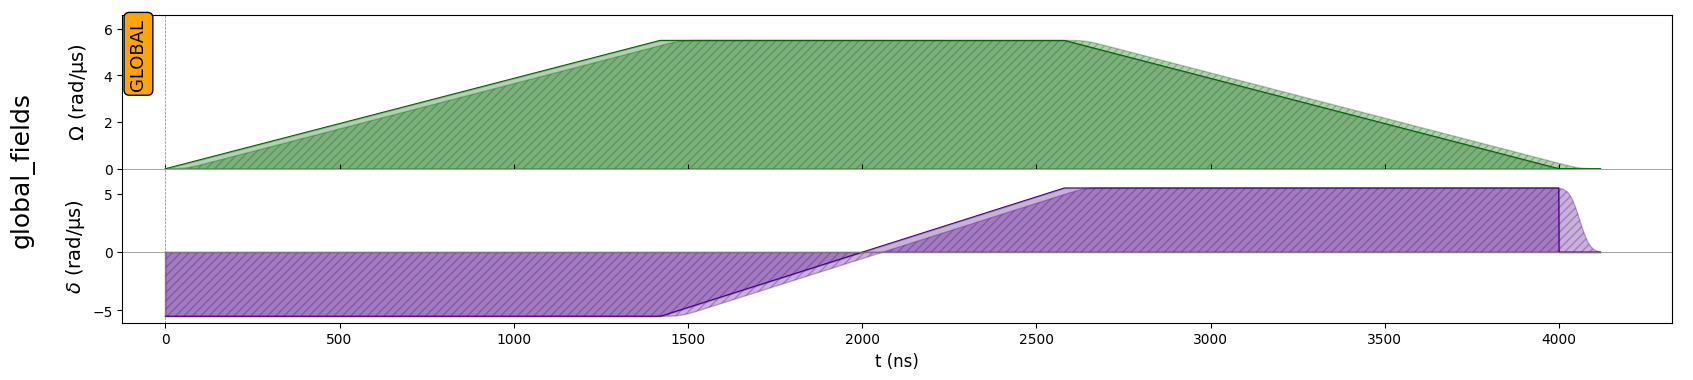

In [114]:
# Run experiment

shots = 500
result = {}

method = "QAA"
nq = 11
backend_name = ["pulser_emulator", "pulser_emulator_noisy", "pasqal_fresnel",'pasqal_emu_tn'][3]
run = ['1st','2nd','3rd'][0]
name_file = f'{nq}_t_{t_tot*1e-3:.0f}e-06'


if backend_name == "pasqal_fresnel":
    register = register.with_automatic_layout(backends[backend_name])

sequence = Sequence(register, backends[backend_name])
sequence.declare_channel('global_fields', 'rydberg_global')
sequence.delay(t_delay,'global_fields')
sequence.add(rise, "global_fields")
sequence.add(sweep, "global_fields")
sequence.add(fall, "global_fields")
#sequence.draw(fig_name=f"./Fields.png",)

if backend_name == "pulser_emulator":
    config = SimConfig()
if backend_name == "pulser_emulator_noisy":
    config = SimConfig(noise=("SPAM"), eta=0.02,epsilon=0.01,epsilon_prime=0.08,runs=30, samples_per_run=5)

if backend_name in ["pulser_emulator", "pulser_emulator_noisy"]:
    emu = QutipEmulator.from_sequence(sequence, sampling_rate = 0.05, evaluation_times=0.1,config=config).run()
    #job = QutipBackend(sequence, config = config).run()
    result["samples"] = emu.sample_final_state(N_samples=shots)
    with open(f"./Data/{backend_name}/{method}/t{t_tot}/{nq}.json", "w") as file:
        json.dump(result,file,cls=NumpyEncoder)
if backend_name == "pasqal_fresnel":
    serialized_sequence = sequence.to_abstract_repr()
    job = {"runs": shots}
    batch = sdk.create_batch(serialized_sequence, [job])
if backend_name == "pasqal_emu_tn":
    serialized_sequence = sequence.to_abstract_repr()
    job = {"runs": shots}
    batch = sdk.create_batch(serialized_sequence, [job], emulator=EmulatorType.EMU_TN)
    
if backend_name == "pasqal_emu_mps":
    serialized_sequence = sequence.to_abstract_repr()
    job = {"runs": shots}
    batch = sdk.create_batch(serialized_sequence, [job], emulator=EmulatorType.EMU_MPS)

if backend_name[:6] == 'pasqal':
    result['id'] = batch.id
    with open(f"./Data/{backend_name}/{method}/{run}-run/{name_file}.json", "w") as file:
        json.dump(result,file,cls=NumpyEncoder)

In [14]:
# Retrieve data from cloud

method = "QAA"
nq = 11
t_tot = 1000
backend_name = ["pulser_emulator", "pulser_emulator_noisy", "pasqal_fresnel",'pasqal_emu_tn'][2]
run = ['1st','2nd','3rd'][1]
name_file = f'{nq}_t_{t_tot*1e-3:.0f}e-06'

with open(f"./Data/{backend_name}/{method}/{run}-run/{name_file}.json", "r") as file:
    result = json.load(file)
batch_id = result['id']
batch = sdk.get_batches(filters=BatchFilters(id=batch_id)).results[0]
for job in batch.ordered_jobs:
    print(f"job-id: {job.id}, status: {job.status}, result: {job.result}")
    if job.status == 'DONE':
        result['samples'] = job.result
        with open(f"./Data/{backend_name}/{method}/{run}-run/{name_file}.json", "w") as file:
            json.dump(result,file,cls=NumpyEncoder)

job-id: c2b645ea-ff71-4eff-b367-9b75a52ae1eb, status: DONE, result: {'01111100000': 17, '11001010100': 12, '11011010000': 12, '11011100000': 10, '10000101110': 9, '10010100010': 9, '01100101100': 9, '10000011110': 9, '11001010101': 7, '10001010100': 7, '11000011100': 7, '01100101000': 7, '10000101010': 6, '11001100100': 6, '10000011010': 6, '10100101110': 6, '10011100000': 6, '11011000000': 6, '10011010000': 5, '11001100000': 5, '11001010000': 5, '10001100100': 5, '10001100101': 5, '10110100010': 5, '01101100100': 5, '10000010101': 5, '11111100000': 5, '11000101100': 4, '00010000010': 4, '10100101010': 4, '10000001110': 4, '01100100000': 4, '00100100110': 4, '01011010000': 4, '11100101100': 4, '01101100000': 4, '01110100000': 4, '11000010100': 3, '11010100000': 3, '11101100000': 3, '01111000000': 3, '11001100101': 3, '01101100101': 3, '10110100000': 3, '01100100100': 3, '10101100100': 3, '01011010001': 3, '01001100101': 3, '01001010100': 3, '10100101100': 3, '00100101110': 3, '10010000

In [15]:
# Postprocessing

method = "QAA"
nq = 11
backend_name = ["pulser_emulator", "pulser_emulator_noisy", "pasqal_fresnel",'pasqal_emu_tn'][2]
run = ['1st','2nd','3rd'][1]
name_file = f'{nq}_t_{t_tot*1e-3:.0f}e-06'

with open(f"./Data/{backend_name}/{method}/{run}-run/{name_file}.json", "r") as file:
    result = json.load(file)
# if backend_name == "pasqal_fresnel":
#     batch_id = list(result.keys())[0]
#     result = result[batch_id]
#     result['samples'] = result.pop('counter')
    

with open(f"./Data/problems/{nq}.json", "r") as file:
    problem = json.load(file)
G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])

cost_evals = defaultdict(int)
for k, v in result["samples"].items():
    cost = cost_function(k, G)
    cost_evals[cost] += v
result["cost"] = cost_evals 
result["min_cost"] = cost_function(problem["sol"], G)

with open(f"./Data/{backend_name}/{method}/{run}-run/{name_file}.json", "w") as file:
    json.dump(result, file)

In [17]:
shots = 500

min_cost = result['min_cost']
prob_succ = result['cost'][min_cost]/shots
print(prob_succ)

0.12
